# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
%pip -q install lightning wandb

!wget -q https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.1 MB/s eta 0:00:00


In [2]:
import wandb

wandb.login(key="648f0ebca50c7021eefe306ab62fcbf0029574da")

wandb: Currently logged in as: jirayuwat12 (myfistteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
%matplotlib inline
import matplotlib as mpl

mpl.font_manager.fontManager.addfont("thsarabunnew-webfont.ttf")  # 3.2+
mpl.rc("font", family="TH Sarabun New")
import torch

# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-01-23 14:19:08--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.03s   

2025-01-23 14:19:08 (10.3 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [5]:
import csv

with open("mp_name_th_en.csv") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=",")
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10], name_en[:10]):
    print(th, en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
import torch

In [8]:
# Preprocessing
input_chars = list(set("".join(name_th)))
output_chars = list(set("".join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars) + 1
output_vocab_size = len(output_chars) + 2  # +2 for special end of sentence token/PADDING
print("There are %d lines and %d unique characters in your input data." % (data_size, vocab_size))
maxlen = len(max(name_th, key=len))  # max input length
maxlen_out = len(max(name_en, key=len))  # max input length

There are 10887 lines and 65 unique characters in your input data.


In [9]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [10]:
# Create a mapping from character to unique index.
input_vocab = ["<PAD>"] + sorted(input_chars)
input_char_to_idx = {char: idx for idx, char in enumerate(input_vocab)}
input_idx_to_char = {idx: char for char, idx in input_char_to_idx.items()}
print(f"Input vocab size: {len(input_vocab)}")

output_vocab = ["<PAD>", "</s>"] + sorted(output_chars)
output_char_to_idx = {char: idx for idx, char in enumerate(output_vocab)}
output_idx_to_char = {idx: char for char, idx in output_char_to_idx.items()}
print(f"Output vocab size: {len(output_vocab)}")

Input vocab size: 65
Output vocab size: 24


In [11]:
# Create X and y
X = []
y = []
for data_index in range(data_size):
    X.append(
        [input_char_to_idx[char] for char in name_th[data_index]]
        + [input_char_to_idx["<PAD>"]] * (maxlen - len(name_th[data_index]))
    )
    y.append(
        [output_char_to_idx[char] for char in name_en[data_index]]
        + [output_char_to_idx["</s>"]]
        + [output_char_to_idx["<PAD>"]] * (maxlen_out - len(name_en[data_index]))
    )

X = torch.tensor(X)
y = torch.tensor(y)

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class NameDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor) -> None:
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

    def __len__(self) -> int:
        return len(self.X)

In [14]:
class NameDataModule(L.LightningDataModule):
    def __init__(self, train_data, y, batch_size, num_workers=0):
        super().__init__()
        self.train_data = train_data
        self.y = y
        self.batch_size = batch_size
        self.num_workers = num_workers

    def collate_fn(self, batch):
        X, y = zip(*batch)
        # One hot encode
        X = F.one_hot(torch.stack(X), num_classes=len(input_char_to_idx)).float()
        y = torch.stack(y)
        return X, y

    def train_dataloader(self):
        train_dataset = NameDataset(self.train_data, self.y)
        return DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

In [15]:
data_module = NameDataModule(X, y, batch_size=32, num_workers=0)

data_loader = data_module.train_dataloader()
for X_batch, y_batch in data_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 20, 65]) torch.Size([32, 20])


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [16]:
def one_step_attention(h: torch.Tensor, s_prev: torch.Tensor, linear_1: nn.Linear, linear_2: nn.Linear) -> torch.Tensor:
    """
    Perform one step of attention mechanism which
    splits the hidden states of the encoder into key and value,
    and uses key and previous hidden state of the decoder to compute attention weights.

    :param h: hidden states of the encoder, shape [batch_size, seq_length, hidden_size]
    :param s_prev: previous hidden state of the decoder, shape [batch_size, hidden_size]
    :param linear_1: nn.Linear for the first linear layer, input size is 2 * hidden_size, output size is hidden_size
    :param linear_2: nn.Linear for the second linear layer, input size is hidden_size, output size is 1
    :return: context, attention weights
    """
    #Split into Key-Value
    _, seq_length, hidden_size = h.size()
    half_hidden_size = hidden_size // 2

    key, value = torch.split(h, half_hidden_size, dim=2)

    s_prev = s_prev.unsqueeze(1).repeat(1, seq_length, 1)
    concatenated_input = torch.cat([key, s_prev], dim=2)

    #Attention function
    M_t = torch.tanh(linear_1(concatenated_input))
    alpha_t = F.softmax(linear_2(M_t), dim=1)

    context = torch.sum(alpha_t * value, dim=1)

    return context, alpha_t

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [17]:
class AttentionModel(L.LightningModule):
    def __init__(self, input_vocab: list[str], learning_rate: float = 0.001) -> None:

        super().__init__()
        self.n_h = 32 #hidden dimensions for encoder
        self.n_s = 32 #hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.input_vocab = input_vocab

        #encoder can be any RNN of your choice
        self.encoder_lstm = nn.LSTM(len(self.input_vocab), self.n_h, batch_first=True)

        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s//2, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_vocab))

        #attention
        self.linear_1 = nn.Linear(3 * self.n_s//2, self.n_s)
        self.linear_2 = nn.Linear(self.n_s, 1)

    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        encoder_out, _ = self.encoder_lstm(src)

        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out+1, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):
            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(encoder_out, decoder_s, self.linear_1, self.linear_2)
            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out
            # Store the attention scores for visualization
            attention_scores.append(attention_score)

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src, target = batch
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join([output_idx_to_char[idx.item()] for idx in pred if idx != 0]))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [38]:
model = AttentionModel(input_vocab, 0.005)

In [39]:
data_module = NameDataModule(X, y, 128, 4)

In [40]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="hw3.1_attention")

In [41]:
trainer = L.Trainer(max_epochs=500, logger=wandb_logger)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./hw3.1_attention/7s8t5qar/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | encoder_lstm      | LSTM             | 12.7 K | train
2 | decoder_lstm_cell | LSTMCell         | 6.4 K  | train
3 | output_layer      | Linear           | 792    | train
4 | linear_1          | Linear           | 1.6 K  | train
5 |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [43]:
EXAMPLES = ["ประยุทธ", "สมชาย", "ธนาธร", "เนวิน", "สุเทพ", "ประวิตร์", "ชัชชาติ"]

# Create test X data
test_X = []
for name in EXAMPLES:
    test_X.append(
        [input_char_to_idx[char] for char in name]
        + [input_char_to_idx["<PAD>"]] * (maxlen - len(name))
    )
test_X = torch.tensor(test_X)

# Create new collate_fn for test dataloader
def collate_fn(batch):
    X = batch
    X = F.one_hot(torch.stack(X), num_classes=len(input_char_to_idx)).float()
    return X

# Create test dataloader
predict_loader = DataLoader(
    test_X, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn
)

In [44]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (encoder_lstm): LSTM(65, 32, batch_first=True)
  (decoder_lstm_cell): LSTMCell(16, 32)
  (output_layer): Linear(in_features=32, out_features=24, bias=True)
  (linear_1): Linear(in_features=48, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)

In [45]:
output = trainer.predict(model, predict_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

phakuttha</s>
somchai</s>
phanaphon</s>
mawin</s>
suthep</s>
prasit</s>
thitahahaatti</s>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [46]:
%matplotlib inline
%pip install -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
prediction, attention_scores = zip(*output)

In [51]:
show_index = 1

# Convert attention scores to numpy and squeeze
attention_scores = attention_scores[show_index]
attention_scores = torch.cat(attention_scores).squeeze().cpu().numpy()
print("Attention scores shape:", attention_scores.shape)

# Plot the attention scores
prediction = prediction[show_index].squeeze().cpu().numpy()
print("Prediction shape:", prediction.shape)

# Create a heatmap matrix for the attention scores
attn_viz = torch.stack([torch.tensor(attention_scores)]).squeeze().cpu().numpy()
attn_viz = attn_viz[: len(EXAMPLES[show_index])+1, : len(prediction)+1]
print("Attention matrix shape:", attn_viz.shape)

# Create a text and label
output_text = [output_idx_to_char[c] for c in prediction]
xlabels = [char for char in EXAMPLES[show_index]] + ["<PAD>"]
print('output_text', output_text)
print('xlabels', xlabels)

Attention scores shape: (19, 20)
Prediction shape: (20,)
Attention matrix shape: (6, 20)
output_text ['s', 'o', 'm', 'c', 'h', 'a', 'i', '</s>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
xlabels ['ส', 'ม', 'ช', 'า', 'ย', '<PAD>']


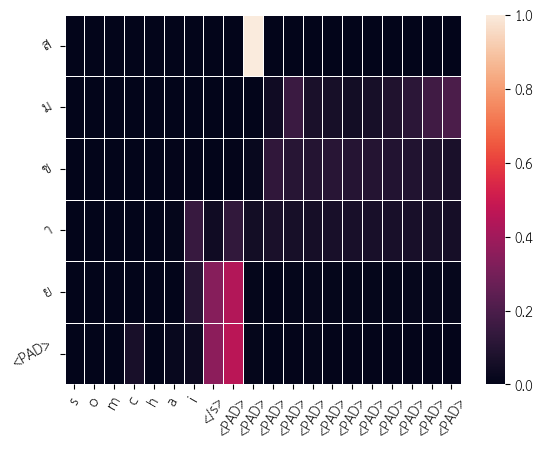

In [52]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_xticklabels(output_text, rotation=60)
ax.set_yticklabels(xlabels, rotation=30)
plt.show()